<a href="https://colab.research.google.com/github/Young1906/dmf/blob/main/predict_cir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

from google.colab import auth; 
auth.authenticate_user()

# SKLearn
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt


## 1. Dataset

In [3]:
%%bigquery --project tiki-dwh df

declare r_date date default '2022-03-08';
declare _window int64 default 30;


with root_product as (
    select 
        p.product_key as product_id,
        p.product_name,
        p.is_free_gift,
        coalesce(
            p.psuper_id,
            p.pmaster_id,
            p.product_key
        ) as root_product_id,

        coalesce(p.cate1, "") as cate1,
        coalesce(p.cate2, "") as cate2,
        coalesce(p.cate3, "") as cate3,
        coalesce(p.cate4, "") as cate4,
        coalesce(p.cate5, "") as cate5,
        coalesce(p.cate6, "") as cate6,
    from 
        `tiki-dwh.dwh.dim_product_full` p    
),

raw as (
    select
        date_diff(e.date_key, date_sub(r_date, interval _window day), day) as _day,
        p.product_id,
        count(distinct e.transaction.transaction_id) as n_transact
        -- safe_cast(e.customer_id as int64) as customer_id,
        -- e.client_id,
        -- e.transaction.transaction_id,
        -- p.product_id,
        -- root_product.*
        --     except ( product_id ),
        
        -- e.event_time
        -- e.date_key


    from 
        `tiki-dwh.trackity.tiki_events_sessions_cross_devices` e,
        unnest ( products ) p 

    left join 
        root_product 
        on root_product.product_id = SAFE_CAST(p.product_id AS int64)
    where 
        e.date_key >= date_sub(r_date, interval _window day)
        and e.date_key < r_date
        -- e.date_key = '{{ ds }}'
        and e.event_name = "purchase"
        and root_product.is_free_gift = false

    group by 1, 2

),

_data as (
    select 

    *

    from 
        raw
        pivot(sum(n_transact) for _day in (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29))
),

w0 as (
select 
    product_id,
    sum(coalesce(cost_vnd, 0)) as cost_w0,
    sum(coalesce(nmv, 0)) as nmv_w0,
    sum(coalesce(activations, 0)) as activations_w0,
    sum(coalesce(sessions, 0)) as sessions_w0,
    sum(coalesce(clicks, 0)) as clicks_w0
    


from 
    `tiki-dwh.olap.tiki_marketing_paid_product_ads` m

where 
    -- date filter
    m.date_key >= date_sub(r_date, interval 7 day)
    and m.date_key < r_date

    -- google channel only
    and m.ads_source in ('gg_shopping')

group by 1
),

w1 as (
select 
    product_id,
    sum(coalesce(cost_vnd, 0)) as cost_w1,
    sum(coalesce(nmv, 0)) as nmv_w1,
    sum(coalesce(activations, 0)) as activations_w1,
    sum(coalesce(sessions, 0)) as sessions_w1,
    sum(coalesce(clicks, 0)) as clicks_w1
    


from 
    `tiki-dwh.olap.tiki_marketing_paid_product_ads` m

where 
    -- date filter
    m.date_key >= r_date
    and m.date_key < date_add(r_date, interval 7 day)

    -- google channel only
    and m.ads_source in ('gg_shopping')

group by 1
)

select 
    w0.*,
    w1.* except( product_id ),
    _data.* except ( product_id ),
    -- if(w1.nmv_w1 = 0, w1.cost_w1 / 1, w1.cost_w1/w1.nmv_w1) as cir_w1,
    -- l30d_transact._arr

from w0 

left join w1 
using (product_id)

left join _data 
using (product_id)

where w0.product_id is not null

## Impact analysis

In [4]:
def impact(df):
    
    def predicate(threshold):
        # Return true if probability of product will generate 0 nmv within next 7 days > threshold
        return df["prob"] > threshold
    
    # Total cost w1
    df = df.fillna(0)
    t_cost = df["cost_w1"].apply(float).sum()
    t_nmv = df["nmv_w1"].apply(float).sum()
    t_activations = df["activations_w1"].apply(float).sum()
    t_sessions = df["sessions_w1"].apply(float).sum()
    t_clicks = df["clicks_w1"].apply(float).sum()

    threshold_x = np.linspace(0.5, 1, 51)
    d_cost = [df[predicate(t)]["cost_w1"].apply(float).sum() for t in threshold_x]
    d_nmv = [df[predicate(t)]["nmv_w1"].apply(float).sum() for t in threshold_x]
    d_activations = [df[predicate(t)]["activations_w1"].apply(float).sum()/t_activations for t in threshold_x]
    d_sessions = [df[predicate(t)]["sessions_w1"].apply(float).sum()/t_sessions for t in threshold_x]
    d_clicks = [df[predicate(t)]["clicks_w1"].apply(float).sum()/t_clicks for t in threshold_x]

    cir_y = [(t_cost - cost) /(t_nmv - nmv) for (cost, nmv) in zip(d_cost, d_nmv)]

    plt.rcParams["figure.figsize"] = [10, 4]
    
    plt.subplot(1,2,1)
    plt.plot(threshold_x, d_nmv, label = "nmv", marker = "x")
    plt.plot(threshold_x, d_cost, label = "cost", marker="v")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(threshold_x, d_activations, label = "activation", marker = 10)
    plt.plot(threshold_x, d_sessions, label = "sessions", marker = 11)
    plt.plot(threshold_x, d_clicks, label = "clicks", marker = 9)
    plt.legend()

    # plt.subplot(1,3,3)
    # plt.plot(threshold_x, cir_y)
    # # plt.plot(threshold_x, d_sessions, label = "sessions", marker = 11)
    # # plt.plot(threshold_x, d_clicks, label = "clicks", marker = 9)
    # plt.legend()

    plt.tight_layout()
    
    plt.show()

    return pd.DataFrame(
        {
            "prob_threshold" : threshold_x,
            "d_cost" : np.array(d_cost)/1e6,
            "d_nmv" : np.array(d_nmv)/1e6
        }
    )
    


In [5]:
df.head()

,product_id,cost_w0,nmv_w0,activations_w0,sessions_w0,clicks_w0,cost_w1,nmv_w1,activations_w1,sessions_w1,...,_20,_21,_22,_23,_24,_25,_26,_27,_28,_29
0,117559173,1175.0000,0,0,0,1.0,235.000,0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,75349272,3574.0915,0,0,4,8.0,4343.787,0,0.0,2.0,...,1.0,1.0,3.0,2.0,2.0,NaN,1.0,NaN,NaN,1.0
2,57554852,1410.0000,0,0,1,6.0,3290.000,0,0.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90351056,235.0000,0,0,0,1.0,235.000,0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,71904710,4473.9065,0,0,0,1.0,2958.227,0,0.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


## Model

In [7]:
def prepare_dataset(df):
    df = df.set_index("product_id")
    df = df.fillna(0)

    # How do you label
    def label(x):
        if x["cost_w1"] < 5e3:
            return 0
        
        if x["nmv_w1"] == 0:
            return 1

        if float(x["cost_w1"]) > float(x["nmv_w1"]):
            return 1
        
        return 0


    df["label"] = df.apply(label,axis=1)

    # Undersampling dataset
    # subset0 = df[df["label"]==0]
    # subset1 = df[df["label"]==1]

    # N = len(subset0) if len(subset0) < len(subset1) else len(subset1)

    # resampled = pd.concat([
    #     subset0.sample(N),
    #     subset1.sample(N)
    # ])

    # print(N)
    # print(len(resampled))

    # print(len(df), len(resampled))
    # X = resampled.drop(columns=["cost_w1", "nmv_w1", "activations_w1", "sessions_w1", "clicks_w1", "label"])
    # y = resampled["label"]

    # Full dataset
    _X = df.drop(columns=["cost_w1", "nmv_w1", "activations_w1", "sessions_w1", "clicks_w1", "label"])
    _y = df["label"]

    return _X, _y

# prepare_dataset(df)

In [8]:
def train(df, estimator, n_cv):
    # Dataset
    X, y = prepare_dataset(df)

    # Split
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y,
    #     random_state = 42)
    
    # Cross validate
    cv_result = cross_validate(
        estimator,
        X, y,
        scoring = 'accuracy',
        cv = n_cv,
        return_estimator = True
    )

    _score = cv_result['test_score']
    # best estimator 
    _idx_best = np.argmax(_score)
    _estimator = cv_result["estimator"][_idx_best]

    return _score, _estimator

### Randomforest only

[0.87433701 0.87865697 0.874385   0.93496052 0.94225646 0.94292846
 0.93402294 0.92070273 0.9127106  0.90690251]
####################
Classification report on entire dataset
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    376930
           1       0.96      0.70      0.81     39736

    accuracy                           0.97    416666
   macro avg       0.96      0.85      0.90    416666
weighted avg       0.97      0.97      0.97    416666



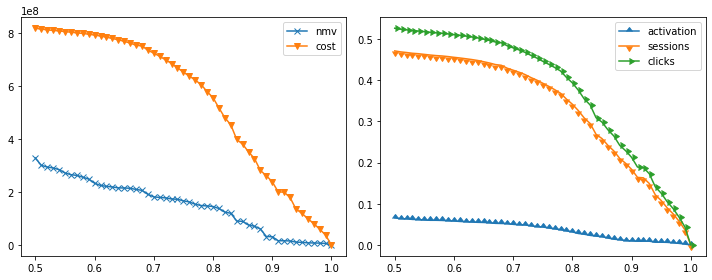

,prob_threshold,d_cost,d_nmv
0,0.50,819.644650,328.847262
1,0.51,816.173984,301.020347
2,0.52,813.779425,294.808247
3,0.53,811.207088,291.129360
4,0.54,809.556152,285.085360
5,0.55,806.840005,272.322321
6,0.56,804.756014,265.798031
7,0.57,802.049738,263.077532
8,0.58,800.171765,256.587052
9,0.59,796.909188,249.186811


In [7]:
# RandomForestClassifier
rfc = Pipeline([
    ("Scaler", StandardScaler()),
    ("RandomForest Classifier", RandomForestClassifier(
        # max_depth = 10, 
        # min_samples_split = 100
    ))
])

_score, _estimator = train(df, rfc, 10)
print(_score)


# # On resampled data
# print("#"*20)
# print("Classification report on resampled dataset")
# (X, y), _ = prepare_dataset(df)
# y_pred = _estimator.predict(X)
# print(classification_report(y, y_pred))

# Prediction on entire dataset
print("#"*20)
print("Classification report on entire dataset")
X, y = prepare_dataset(df)
y_pred = _estimator.predict(X)

print(classification_report(y, y_pred))

# Prediction probability
df_copy = df.copy()
df_copy["prob"] = _estimator.predict_proba(X)[:, 1]

impact(df_copy)

In [8]:
# impact(df_copy)

### Randomforest 2

[0.88523292 0.88657691 0.88448892 0.94504044 0.95188038 0.95108839
 0.93671099 0.92046273 0.91215859 0.90666251]
####################
Classification report on entire dataset
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    376930
           1       0.79      0.47      0.59     39736

    accuracy                           0.94    416666
   macro avg       0.87      0.73      0.78    416666
weighted avg       0.93      0.94      0.93    416666



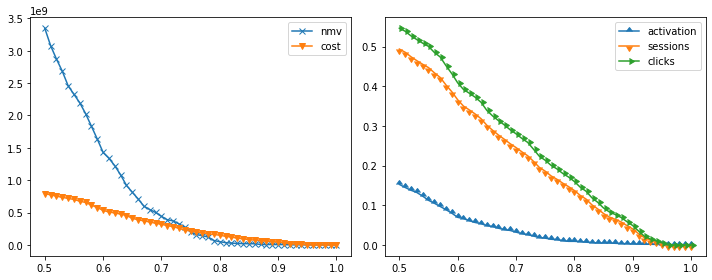

,prob_threshold,d_cost,d_nmv
0,0.50,791.940273,3347.929683
1,0.51,775.186744,3078.691515
2,0.52,753.816083,2871.843611
3,0.53,735.724341,2684.121039
4,0.54,719.063932,2459.366439
5,0.55,703.436585,2327.139092
6,0.56,676.270209,2195.836931
7,0.57,656.267220,2028.036782
8,0.58,615.632865,1833.219985
9,0.59,578.468344,1634.933520


In [9]:
# RandomForestClassifier
rfc = Pipeline([
    ("Scaler", StandardScaler()),
    ("RandomForest Classifier", RandomForestClassifier(
        # max_depth = 10, 
        min_samples_split = 50
    ))
])

_score, _estimator = train(df, rfc, 10)
print(_score)


# # On resampled data
# print("#"*20)
# print("Classification report on resampled dataset")
# (X, y), _ = prepare_dataset(df)
# y_pred = _estimator.predict(X)
# print(classification_report(y, y_pred))

# Prediction on entire dataset
print("#"*20)
print("Classification report on entire dataset")
X, y = prepare_dataset(df)
y_pred = _estimator.predict(X)

print(classification_report(y, y_pred))

# Prediction probability
df_copy = df.copy()
df_copy["prob"] = _estimator.predict_proba(X)[:, 1]

impact(df_copy)

### PCA

In [ ]:
# RandomForestClassifier
pca = Pipeline([
    ("Scaler", StandardScaler()),
    ("PCA", PCA(10)),
    ("RandomForest Classifier", RandomForestClassifier(
        # max_depth = 10, 
        # min_samples_split = 100
    ))
])

_score, _estimator = train(df, pca, 10)
print(_score)

# Prediction on entire dataset
print("#"*20)
print("Classification report on entire dataset")
X, y = prepare_dataset(df)
y_pred = _estimator.predict(X)

print(classification_report(y, y_pred))
df_copy = df.copy()
df_copy["prob"] = _estimator.predict_proba(X)[:, 1]

impact(df_copy)

In [ ]:
# df = df.fillna(0)
# df["nmv_w0"].apply(lambda x: 1 if x == 0 else x)
# df["nmv_w1"].apply(lambda x: 1 if x == 0 else x)

# df["cir_w0"] = df["cost_w0"].apply(float) / df["nmv_w0"].apply(float)
# df["cir_w1"] = df["cost_w1"].apply(float) / df["nmv_w1"].apply(float)

In [ ]:
# df["label_w0"] = df["cir_w0"].apply(lambda x: "<.5" if x < .5 else ">.5")
# df["label_w1"] = df["cir_w1"].apply(lambda x: "<.5" if x < .5 else ">.5")

# pd.pivot_table(
#     df,
#     index="label_w0",
#     columns="label_w1",
#     aggfunc="count",
#     values=["product_id"]
# )

In [ ]:
# pd.pivot_table(
#     df,
#     index="label_w0",
#     columns="label_w1",
#     aggfunc="sum",
#     # values=["nmv_w1"]
# ).applymap(float).values / 1e9

In [ ]:
# pd.pivot_table(
#     df,
#     index="label_w0",
#     columns="label_w1",
#     aggfunc="sum",
#     values=["cost_w1"]
# ).applymap(float).values / 1e9